<a href="https://colab.research.google.com/github/luthierman/quantum-research-colab/blob/main/DQN_torch_ultimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install wandb
!pip install autoray==0.2.5
!pip install pennylane

In [ ]:
# %%writefile experience_replay.py
from collections import namedtuple,deque
import random
import numpy as np
import pandas as pd
import torch
class ER_Memory(object):
    def __init__(self, capacity, device="cpu"):
        self.capacity = capacity
        self.device = device
        self.states = torch.zeros((capacity, 4), dtype=torch.float32, device=self.device)
        self.actions = torch.zeros((capacity,1), dtype=torch.int64,device=self.device)
        self.rewards = torch.zeros((capacity,1), dtype=torch.int64,device=self.device)
        self.next_states = torch.zeros((capacity, 4), dtype=torch.float32,device=self.device)
        self.dones = torch.zeros(capacity, dtype=torch.int64,device=self.device)
        self.index = 0
        self._len = 0

    def remember(self, *args):
        exp = [*args]

        self.states[self.index] = torch.from_numpy(exp[0])
        self.actions[self.index] = int(exp[1])
        self.rewards[self.index] = exp[2]
        self.next_states[self.index] = torch.from_numpy(exp[3])
        self.dones[self.index] = exp[4]

        self.index = (self.index+1)%self.capacity
        self._len = min(self._len+1, self.capacity)
    def sample(self, batch_size):
        batch_idxs= np.random.choice(np.arange(self._len), size=min(self._len, batch_size), replace=True)
        
        return self.states[batch_idxs], self.actions[batch_idxs], self.rewards[batch_idxs], self.next_states[batch_idxs], self.dones[batch_idxs]

    def __len__(self):
      return self._len

class PER_Memory(object):
    def __init__(self, capacity, device="cpu"):
        self.e = 0.1
        self.alpha = 0.6
        self.beta = 0.4
        self.beta_per = 0.01
        self.capacity = capacity
        self.device = device

        self.states = torch.zeros((capacity, 4), dtype=torch.float32, device=self.device)
        self.actions = torch.zeros((capacity,1), dtype=torch.int64,device=self.device)
        self.rewards = torch.zeros((capacity,1), dtype=torch.int64,device=self.device)
        self.next_states = torch.zeros((capacity, 4), dtype=torch.float32,device=self.device)
        self.dones = torch.zeros(capacity, dtype=torch.int64,device=self.device)
        self.priorities = torch.zeros((capacity,1), dtype=torch.float32,device=self.device)
        self.index = 0
        self._len = 0
        
    def remember(self, *args):
        exp = [*args]
        self.states[self.index] = torch.from_numpy(exp[0])
        self.actions[self.index] = int(exp[1])
        self.rewards[self.index] = exp[2]
        self.next_states[self.index] = torch.from_numpy(exp[3])
        self.dones[self.index] = exp[4]
        self.priorities[self.index] = max(self.priorities.max(), 1)
        self.index = (self.index+1)%self.capacity
        self._len = min(self._len+1, self.capacity)

    def get_probabilities(self):
        scaled_priorities = self.priorities.pow(self.alpha)
        sample_probabilities = scaled_priorities/ torch.sum(scaled_priorities)
        return sample_probabilities

    def get_importance(self, probabilities):
        importance = (1/self._len) * (1/probabilities)
        importance_normalized = importance / np.max(importance)
        return importance_normalized

    def sample(self, batch_size):
        sample_probs = self.get_probabilities()[:self._len].detach().numpy().flatten()
        batch_idxs = np.random.choice(np.arange(self._len),
                                      size=min(self._len, batch_size),
                                      p=sample_probs, replace=True)
        minibatch = self.states[batch_idxs], self.actions[batch_idxs], self.rewards[batch_idxs], self.next_states[batch_idxs], self.dones[batch_idxs]
        w = self.get_importance(sample_probs[batch_idxs])
        return batch_idxs, minibatch,  w

    def __len__(self):
        return self._len
    def update_priorities(self, indices, priorities):
        clipped_errors = np.minimum(np.absolute(priorities.detach().numpy()), 1.0)
        ps = np.power(clipped_errors, self.alpha)
        for i,p in zip( indices, ps):
          self.priorities[i]= p+self.e


In [ ]:
# %%writefile dense_net_per.py
import torch.cuda
import torch.nn as nn
import torch.nn.functional as F

class Dense_Net(nn.Module):
    def __init__(self, n_layers=5):
        super(Dense_Net, self).__init__()
        self.linear_in = nn.Linear(4, 64)
        self.layers = nn.ModuleList()

        for i in range(n_layers-2):
          self.layers.append(nn.Linear(64, 64))
       
        self.linear_out = nn.Linear(64,2)
        nn.init.xavier_normal_(self.linear_in.weight)
        for l in self.layers:
          nn.init.xavier_normal_(l.weight)
        nn.init.xavier_normal_(self.linear_out.weight)

    def forward(self, x):
        x = F.relu(self.linear_in(x))
        for l in self.layers:
          x = F.relu(l(x))
        x = self.linear_out(x)
        return x

Reupload_Net(
  (qvc): <Quantum Torch Layer: func=circuit>
)

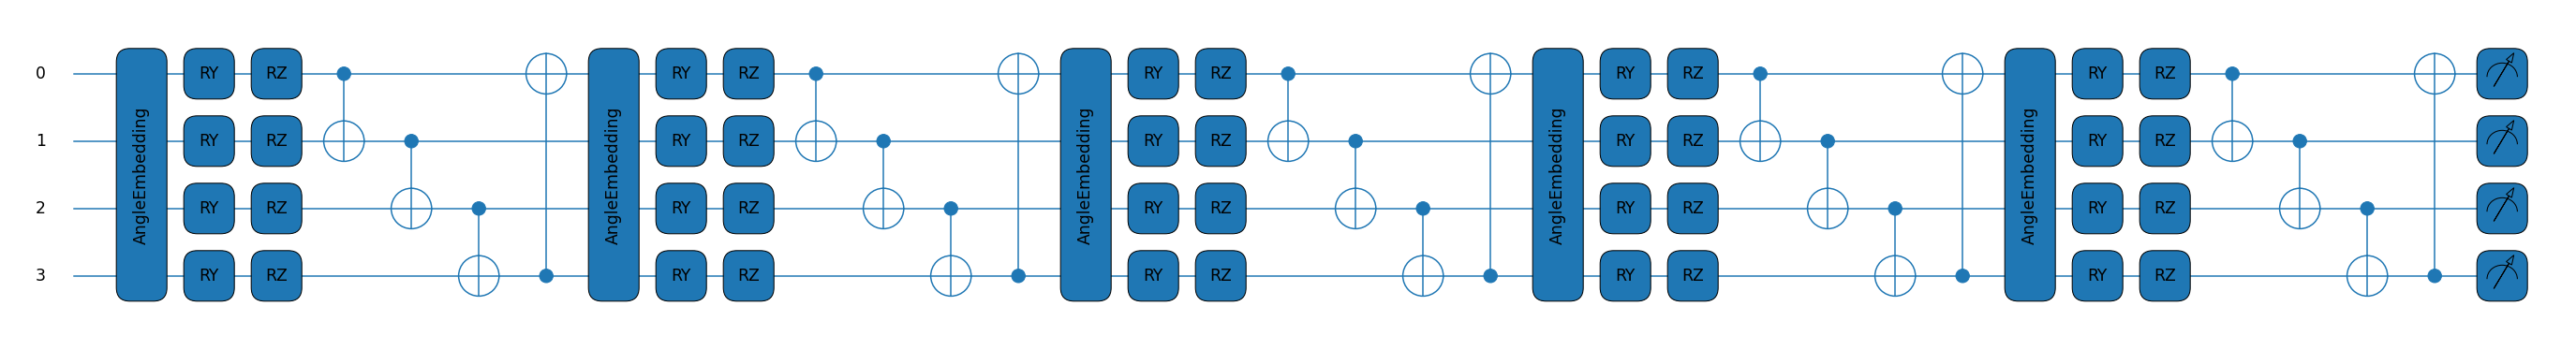

In [ ]:
import pennylane as qml
from pennylane import numpy as np
from torch import nn
import torch
import matplotlib.pyplot as plt

class Reupload_Net(nn.Module):
    def __init__(self, n_layers=3, n_qubits=4):
      super(Reupload_Net, self).__init__()
      self.n_layers = n_layers
      self.n_qubits = n_qubits
      self.weight_shapes = {"weights": (self.n_layers, self.n_qubits, 3), "w_in": (self.n_layers,self.n_qubits)}
      dev = qml.device("default.qubit.autograd", wires=self.n_qubits)
      def layer( W):
        for i in range(self.n_qubits):
          qml.RY(W[i,1], wires=i)
          qml.RZ(W[i,2], wires=i)
      @qml.qnode(dev, interface='torch', diff_method="adjoint")
      def circuit(weights, inputs, w_in):
          # W: Layer Variable Parameters, s: State Variable
          
          for i in range(self.n_layers):
            # Weighted Input Encoding
            qml.AngleEmbedding(torch.tanh(torch.multiply(inputs,w_in[i])), wires=range(self.n_qubits), rotation="X")
            # Parameterized Layer
            layer(weights[i])
            # Entangling
            for j in range(n_qubits):
                qml.CNOT(wires=[j%self.n_qubits,(j+1)%self.n_qubits])
          return [qml.expval(qml.PauliZ(0)@qml.PauliZ(1)), qml.expval(qml.PauliZ(2)@qml.PauliZ(3))]
      self.qvc = qml.qnn.TorchLayer(circuit, self.weight_shapes,init_method=nn.init.uniform_)
      d = self.qvc.state_dict()
      d["w_in"] =torch.autograd.Variable(torch.ones(n_layers,n_qubits,requires_grad=True))
      self.w_out = nn.Parameter(torch.ones(1,2),requires_grad=True)
      self.qvc.load_state_dict(d)
      W = torch.DoubleTensor(self.n_layers,self.n_qubits,3)
      ins = torch.ones(self.n_layers)
      # qml.drawer.use_style("black_white_dark")
      self.fig, self.ax = qml.draw_mpl(circuit,fontsize="xx-large")(weights=W , inputs=torch.tensor([[0,0,0,0]]) ,w_in=ins)
      self.fig.show()   
    def forward(self, x):
      # rescaled out 
      out =  (self.qvc(x)+1)/2
      return torch.mul(out, self.w_out)

      
    def save_visual(self,path):
      self.fig.savefig(path)

Reupload_Net(5)


In [ ]:
# %%writefile hyperparameters.py

LR = 0.001
GAMMA = 0.95
EPSILON = 1.0
EPSILON_DECAY= 0.99
EPSILON_MIN = 0.01
N_EPISODES = 200
BATCH_SIZE = 16
BUFFER_SIZE = 100000
UPDATE_TARGET = 30
UPDATE_MODEL = 10
TRAIN_START = 1
is_DDQN = False
use_PER = False

In [ ]:
from copy import copy
import gym
import matplotlib.pyplot as plt
from torch.optim import *
from collections import deque
import random
import numpy as np
import os
import time
import datetime
from pathlib import Path
import wandb

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

class DQN(object):
    def __init__(self, model, config, env="CartPole-v0") -> None:
        # GYM environment
        self.env = gym.make(env)
        self.action_space = self.env.action_space.n
        self.state_space = self.env.observation_space.shape[0]
        print("State Space: {}".format(self.state_space))
        print("Action Space: {}".format(self.action_space))

        # HYPERPARAMETERS
        self.config = config
        print(config)
        self.lr = self.config["learning_rate"]
        self.gamma = self.config["gamma"]
        self.epsilon = self.config["epsilon"]
        self.epsilon_decay = self.config["epsilon_decay"]
        self.epsilon_min = self.config["epsilon_min"]
        self.batch = self.config["batch_size"]
        self.episodes = self.config["n_episodes"]
        self.buff = self.config["buffer_size"]
        self.update_target = self.config["update_target"]
        self.update_model = self.config["update_model"]
        self.train_start = self.config["train_start"]
        self.ddqn= self.config["is_DDQN"]
        self.use_per = self.config["use_PER"]
        self.reupload= self.config["is_Reupload"]
        self.n_layers = self.config["n_layers"]

        use_cuda = False
        
        self.device = torch.device("cuda" if use_cuda else "cpu")
        
        # Q-network
        self.q_network = model(self.n_layers)
        # Quantum Reupload prep
        if self.reupload:
          
          self.param_in = [self.q_network.qvc.w_in]
          self.param_weights = [self.q_network.qvc.weights]
          self.param_out = [self.q_network.w_out]
          self.opt_in =Adam(self.param_in, lr=.001,amsgrad=True)
          self.opt_var =Adam(self.param_weights,lr=self.lr,amsgrad=True)
          self.opt_out =Adam(self.param_out, lr=.3,amsgrad=True)
        else:
          self.opt = Adam(self.q_network.parameters(),lr=self.lr,amsgrad=True)
        # Target network
        self.target = model(self.n_layers)
        self.sync_weights()
        # GPU setup

        if use_cuda:
            print("GPU being used:", torch.cuda.get_device_name(0))
            self.q_network.cuda(self.device)
            self.target.cuda(self.device)
        self.target.eval()
        
        # DQN setup
        self.loss_fn = torch.nn.MSELoss()
        if self.use_per:
          self.memory = PER_Memory(self.buff)
        else:
          self.memory = ER_Memory(self.buff)
        self.counter = 0
        self.step = 0
        self.current_episode = 0

        # stat tracking
        self.rewards = []
        self.avg_rewards = []
        self.losses = []
        self.q_values = []


        self.name = "DQN_{}".format(datetime.datetime.now())
        self.path = "{}_logs".format(self.name)
        self.save_path = "{}/{}_ep_{}.pt".format(self.path,self.name,self.current_episode+1)
        os.makedirs(self.path, exist_ok=False)

    def preprocess_state(self,x):
        x = np.stack(x)
        state = torch.FloatTensor(x).to(self.device)
        return state
    
    def sync_weights(self):
        self.target.load_state_dict(self.q_network.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.remember(state, action, reward, next_state, done)
        self.counter += 1

    def get_action(self, obs):
        if len(self.memory) > self.batch:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
        if np.random.random() <= self.epsilon:
            return self.env.action_space.sample()
        else:
            self.q_network.eval()
            obs = self.preprocess_state([obs])
            return int(self.q_network(obs).argmax().detach())

    def learn(self):
        if len(self.memory) < self.train_start:
            return 0
        if self.use_per:
          idx, minibatch, ws = self.memory.sample(self.batch)
        else: 
          minibatch = self.memory.sample(min(len(self.memory), self.batch))
        states, actions, rewards, next_states, dones = minibatch
        self.q_network.train()
        self.target.eval()
        # DDQN
        if self.ddqn:
          Q = self.q_network.forward(states).gather(1, actions).squeeze(-1)# Q(s, a, wq)
          A_best = self.q_network.forward(next_states).argmax(1).reshape(-1,1) # 
          Q_next = self.target.forward(next_states).gather(1, A_best).squeeze(-1) # max _a Q(ns, argmax_a(Q(ns, a, wq)) , wt)
        # DQN
        else:
          Q = self.q_network.forward(states).gather(1, actions).squeeze(-1)# Q(s, a, wq)
          Q_next = self.target.forward(next_states).max(1)[0].detach() # max _a Q(ns, a, wt)
        y = torch.flatten(rewards) + self.gamma *(1-torch.flatten(dones)) * Q_next # bellman 
        if self.use_per:
          # PER
          error = y-Q
          self.memory.update_priorities(idx, error)
          # REUPLOAD QVC
          if self.reupload:
            self.opt_in.zero_grad(set_to_none=True)
            self.opt_var.zero_grad(set_to_none=True)
            self.opt_out.zero_grad(set_to_none=True)
            loss = torch.multiply((error).pow(2),self.preprocess_state(ws).pow(1-self.epsilon))
            loss=loss.mean()
            loss.backward()
            self.opt_in.step()
            self.opt_var.step()
            self.opt_out.step()
          # Regular optimization
          else:
            self.opt.zero_grad(set_to_none=True)
            loss = torch.multiply((error).pow(2),self.preprocess_state(ws))
            loss=loss.mean()
            loss.backward()
            self.opt.step()
        # ER
        else:
          # REUPLOAD QVC
          if self.reupload:
            self.opt_in.zero_grad(set_to_none=True)
            self.opt_var.zero_grad(set_to_none=True)
            self.opt_out.zero_grad(set_to_none=True)
            loss = self.loss_fn(Q,y)
            loss.backward()
            self.opt_in.step()
            self.opt_var.step()
            self.opt_out.step()
          # Regular optimization
          else:
            self.opt.zero_grad(set_to_none=True)
            loss = self.loss_fn(Q,y)
            loss.backward()
            self.opt.step()
        return float(loss), float(Q.mean().detach())

    def train_episode(self):
        start_time = time.time()
        s1 = self.env.reset()
        steps = 1
        train_steps = 0
        done = False
        total_reward = 0
        total_loss = 0 
        total_q = 0
        while not done:
            # self.env.render()
            action = self.get_action(s1)
            s2, reward, done, _ = self.env.step(action)
            total_reward+=reward
            self.remember(s1,action,reward,s2,done)
            if done:
                episode_time = time.time() - start_time
                # Store Trackable Stats
                self.rewards.append(total_reward),
                avg = np.mean(self.rewards[-50:])
                if train_steps!=0:
                  self.losses.append(total_loss/train_steps)
                  self.q_values.append(total_q/train_steps)
                else:
                  self.losses.append(0)
                  self.q_values.append(0)
                self.avg_rewards.append(avg)
                print("\rEpisode {c_ep}/{n_ep} [{t} sec.]|| 50 Running Avg {a}, Episode Reward {tr}, Loss {l}, Q {q}, eps {eps}".format(
                      c_ep=self.current_episode+1,
                      n_ep=self.episodes,
                      t= np.round(episode_time, 3),
                      a=np.round(avg, 3),
                      tr=np.round(total_reward, 3),
                      l=np.round(self.losses[self.current_episode], 3),
                      q=np.round(self.q_values[self.current_episode],3),
                      eps=np.round(self.epsilon, 3)
                  ),flush=True, end="")
                self.save_path = "{}/{}_ep_{}.pt".format(self.path,self.name,self.current_episode+1)
                torch.save(self.q_network.state_dict(), self.save_path)
                self.current_episode+=1
                break
            s1 = s2
            if self.counter%self.update_model==0:
              loss, q = self.learn()
              if loss != None:
                  total_loss += loss
                  total_q += q
                  train_steps+=1
            if self.counter %self.update_target==0:
                self.sync_weights()
            steps+=1
      


In [ ]:
## DQN CLASSICAL ER
torch.cuda.empty_cache()
# import wandb
config = {
  "learning_rate": .001,
  "n_episodes": 2000,
  "batch_size": BATCH_SIZE,
  "gamma": GAMMA,
  "epsilon": EPSILON,
  "epsilon_decay": EPSILON_DECAY,
  "epsilon_min": EPSILON_MIN,
  "buffer_size": 10000,
  "update_target": 30,
  "update_model": 10,
  "train_start": TRAIN_START,
  "is_DDQN": False,
  "use_PER": True,
  "is_Reupload":False,
  "n_layers":3
}

# run1 = wandb.init(project="quantum_research", 
#                  entity="luthier-man",
#                  name="DQN Classical ER",
#                  config=config1,
#                  monitor_gym=True,
#                  save_code=True)
# run1.log_code(".")
# run1.watch(agent1.q_network, log="all",log_freq=1,
#           criterion=agent1.loss_fn, log_graph=True)
agent_dqn = DQN(Dense_Net, config)
for i in range(agent_dqn.episodes):
    agent_dqn.train_episode()
config["is_DDQN"]=True
agent_ddqn = DQN(Dense_Net, config)
for i in range(agent_ddqn.episodes):
    agent_ddqn.train_episode()
config["is_DDQN"]=False
config["use_PER"]=True
agent_dqn_per = DQN(Dense_Net, config)
for i in range(agent_dqn_per.episodes):
    agent_dqn_per.train_episode()
config["is_DDQN"]=True
config["use_PER"]=True
agent_ddqn_per = DQN(Dense_Net, config)
for i in range(agent_ddqn_per.episodes):
    agent_ddqn_per.train_episode()

    # run1.log({"rewards":agent1.rewards[i],
    #          "loss": agent1.losses[i],
    #          "avg_reward": agent1.avg_rewards[i],
    #          "Q-value": agent1.q_values[i]})
    # run1.save("{}/*pt".format(agent1.path))
    # if agent3.rewards[i]==200 and alert:
        # wandb.alert(title="Reached 200", 
        #         text="{} Agent has reached 200 points!!!".format("DQN Classical ER"))
        # alert= False

# run1.finish()


State Space: 4
Action Space: 2
{'learning_rate': 0.001, 'n_episodes': 2000, 'batch_size': 16, 'gamma': 0.95, 'epsilon': 1.0, 'epsilon_decay': 0.99, 'epsilon_min': 0.01, 'buffer_size': 10000, 'update_target': 30, 'update_model': 10, 'train_start': 1, 'is_DDQN': False, 'use_PER': True, 'is_Reupload': False, 'n_layers': 3}
Episode 2000/2000 [0.113 sec.]|| 50 Running Avg 150.18, Episode Reward 162.0, Loss 0.003, Q 17.477, eps 0.01State Space: 4
Action Space: 2
{'learning_rate': 0.001, 'n_episodes': 2000, 'batch_size': 16, 'gamma': 0.95, 'epsilon': 1.0, 'epsilon_decay': 0.99, 'epsilon_min': 0.01, 'buffer_size': 10000, 'update_target': 30, 'update_model': 10, 'train_start': 1, 'is_DDQN': True, 'use_PER': True, 'is_Reupload': False, 'n_layers': 3}
Episode 2000/2000 [0.087 sec.]|| 50 Running Avg 124.52, Episode Reward 130.0, Loss 0.054, Q 16.659, eps 0.01State Space: 4
Action Space: 2
{'learning_rate': 0.001, 'n_episodes': 2000, 'batch_size': 16, 'gamma': 0.95, 'epsilon': 1.0, 'epsilon_decay':

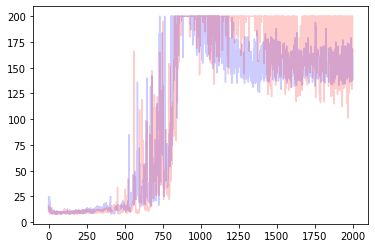

In [ ]:
plt.plot(agent_dqn.rewards, color='blue', alpha=0.2, label='Reward')
plt.plot(agent_ddqn.rewards, color='purple', alpha=0.2, label='Reward')
plt.plot(agent_dqn_per.rewards, color='red', alpha=0.2, label='Reward')
plt.plot(agent_ddqn_per.rewards, color='orange', alpha=0.2, label='Reward')

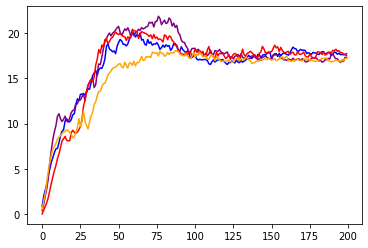

In [ ]:
plt.plot(agent_dqn.q_values, color='blue', label='Reward')
plt.plot(agent_ddqn.q_values, color='purple', label='Reward')
plt.plot(agent_dqn_per.q_values, color='red', label='Reward')
plt.plot(agent_ddqn_per.q_values, color='orange', label='Reward')

In [ ]:
config["is_DDQN"]=False
config["use_PER"]=False
config["is_Reupload"]=True
agent_qdqn = DQN(Reupload_Net, config)
for i in range(agent_qdqn.episodes):
    agent_qdqn.train_episode()

In [ ]:
## DDQN CLASSICAL ER
torch.cuda.empty_cache()
config2 = {
  "learning_rate": LR,
  "n_episodes": N_EPISODES,
  "batch_size": BATCH_SIZE,
  "gamma": GAMMA,
  "epsilon": EPSILON,
  "epsilon_decay": EPSILON_DECAY,
  "epsilon_min": EPSILON_MIN,
  "buffer_size": BUFFER_SIZE,
  "update_target": UPDATE_TARGET,
  "update_model": UPDATE_MODEL,
  "train_start": TRAIN_START,
  "is_DDQN": True,
  "use_PER": False,
  "is_Reupload":False,
  "n_layers":3
}

agent2 = DQN(Dense_Net, config2)
run2 = wandb.init(project="quantum_research", 
                 entity="luthier-man",
                 name="DDQN Classical ER",
                 config=config2,
                 monitor_gym=True,
                 save_code=True)
run2.log_code(".")
run2.watch(agent2.q_network, log="all",log_freq=1,
          criterion=agent2.loss_fn, log_graph=True)
print(agent2.name)
alert = True

for i in range(agent2.episodes):
    agent2.train_episode()

    run2.log({"rewards":agent2.rewards[i],
             "loss": agent2.losses[i],
             "avg_reward": agent2.avg_rewards[i],
             "Q-value": agent2.q_values[i]})
    run2.save("{}/*pt".format(agent2.path))
    if agent2.rewards[i]==200 and alert:
        wandb.alert(title="Reached 200", 
                text="{} Agent has reached 200 points!!!".format("DDQN Classical ER"))
        alert=False
wandb.alert(title="Finished", 
    text="{} Run is finished".format("DDQN Classical ER"))
run2.finish()


In [ ]:
## DQN CLASSICAL PER
torch.cuda.empty_cache()
config3 = {
  "learning_rate": LR,
  "n_episodes": N_EPISODES,
  "batch_size": BATCH_SIZE,
  "gamma": GAMMA,
  "epsilon": EPSILON,
  "epsilon_decay": EPSILON_DECAY,
  "epsilon_min": EPSILON_MIN,
  "buffer_size": BUFFER_SIZE,
  "update_target": UPDATE_TARGET,
  "update_model": UPDATE_MODEL,
  "train_start": TRAIN_START,
  "is_DDQN": False,
  "use_PER": True,
  "is_Reupload":False,
  "n_layers":3
}

agent3 = DQN(Dense_Net, config3)
run3 = wandb.init(project="quantum_research", 
                 entity="luthier-man",
                 name="DQN Classical PER",
                 config=config3,
                 monitor_gym=True,
                 save_code=True)
run3.log_code(".")
run3.watch(agent3.q_network, log="all",log_freq=1,
          criterion=agent3.loss_fn, log_graph=True)

print(agent3.name)
alert = True
for i in range(agent3.episodes):
    agent3.train_episode()

    run3.log({"rewards":agent3.rewards[i],
             "loss": agent3.losses[i],
             "avg_reward": agent3.avg_rewards[i],
             "Q-value": agent3.q_values[i]})
    run3.save("{}/*pt".format(agent3.path))
    if agent3.rewards[i]==200 and alert:
        wandb.alert(title="Reached 200", 
                text="{} Agent has reached 200 points!!!".format("DQN Classical PER"))
        alert=False
wandb.alert(title="Finished", 
    text="{} Run is finished".format("DQN Classical PER"))
run3.finish()


In [ ]:
## DDQN CLASSICAL PER
torch.cuda.empty_cache()
config4 = {
  "learning_rate": LR,
  "n_episodes": N_EPISODES,
  "batch_size": BATCH_SIZE,
  "gamma": GAMMA,
  "epsilon": EPSILON,
  "epsilon_decay": EPSILON_DECAY,
  "epsilon_min": EPSILON_MIN,
  "buffer_size": BUFFER_SIZE,
  "update_target": UPDATE_TARGET,
  "update_model": UPDATE_MODEL,
  "train_start": TRAIN_START,
  "is_DDQN": True,
  "use_PER": True,
  "is_Reupload":False,
  "n_layers":3
}

agent4 = DQN(Dense_Net, config4)
run4 = wandb.init(project="quantum_research", 
                 entity="luthier-man",
                 name="DDQN Classical PER",
                 config=config4,
                 monitor_gym=True,
                 save_code=True)
run4.log_code(".")
run4.watch(agent4.q_network, log="all",log_freq=1,
          criterion=agent4.loss_fn, log_graph=True)
print(agent4.name)
alert = True

for i in range(agent4.episodes):
    agent4.train_episode()

    run4.log({"rewards":agent4.rewards[i],
             "loss": agent4.losses[i],
             "avg_reward": agent4.avg_rewards[i],
             "Q-value": agent4.q_values[i]})
    run4.save("{}/*pt".format(agent4.path))
    if agent4.rewards[i]==200 and alert:
        wandb.alert(title="Reached 200", 
                text="{} Agent has reached 200 points!!!".format("DDQN Classical PER"))
        alert = False
wandb.alert(title="Finished", 
    text="{} Run is finished".format("DDQN Classical PER"))
run4.finish()


In [ ]:
# DQN Quantum ER
torch.cuda.empty_cache()
config5 = {
  "learning_rate": LR,
  "n_episodes": N_EPISODES,
  "batch_size": BATCH_SIZE,
  "gamma": GAMMA,
  "epsilon": EPSILON,
  "epsilon_decay": EPSILON_DECAY,
  "epsilon_min": EPSILON_MIN,
  "buffer_size": BUFFER_SIZE,
  "update_target": UPDATE_TARGET,
  "update_model": UPDATE_MODEL,
  "train_start": TRAIN_START,
  "is_DDQN": False,
  "use_PER": False,
  "is_Reupload":True,
  "n_layers":3
}

agent5 = DQN(Reupload_Net, config5)
run5 = wandb.init(project="quantum_research", 
                 entity="luthier-man",
                 name="DQN Quantum Reupload ER",
                 config=config5,
                 monitor_gym=True,
                 save_code=True)
run5.log_code(".")
run5.watch(agent5.q_network, log="all",log_freq=1,
          criterion=agent5.loss_fn, log_graph=True)
print(agent5.name)
alert = True

for i in range(agent5.episodes):
    agent5.train_episode()

    run5.log({"rewards":agent5.rewards[i],
             "loss": agent5.losses[i],
             "avg_reward": agent5.avg_rewards[i],
             "Q-value": agent5.q_values[i]})
    run5.save("{}/*pt".format(agent5.path))
    if agent5.rewards[i]==200 and alert:
        wandb.alert(title="Reached 200", 
                text="{} Agent has reached 200 points!!!".format("DQN Quantum Reupload ER"))
        alert=False
wandb.alert(title="Finished", 
    text="{} Run is finished".format("DQN Quantum Reupload ER"))
run5.finish()


In [ ]:
# DDQN Quantum ER
torch.cuda.empty_cache()
config6 = {
  "learning_rate": LR,
  "n_episodes": N_EPISODES,
  "batch_size": BATCH_SIZE,
  "gamma": GAMMA,
  "epsilon": EPSILON,
  "epsilon_decay": EPSILON_DECAY,
  "epsilon_min": EPSILON_MIN,
  "buffer_size": BUFFER_SIZE,
  "update_target": UPDATE_TARGET,
  "update_model": UPDATE_MODEL,
  "train_start": TRAIN_START,
  "is_DDQN": True,
  "use_PER": False,
  "is_Reupload":True,
  "n_layers":3
}

agent6 = DQN(Reupload_Net, config6)
run6 = wandb.init(project="quantum_research", 
                 entity="luthier-man",
                 name="DDQN Quantum Reupload ER",
                 config=config6,
                 monitor_gym=True,
                 save_code=True)
run6.log_code(".")
run6.watch(agent6.q_network, log="all",log_freq=1,
          criterion=agent6.loss_fn, log_graph=True)
print(agent6.name)
alert = True
for i in range(agent6.episodes):
    agent6.train_episode()

    run6.log({"rewards":agent6.rewards[i],
             "loss": agent6.losses[i],
             "avg_reward": agent6.avg_rewards[i],
             "Q-value": agent6.q_values[i]})
    run6.save("{}/*pt".format(agent6.path))
    if agent6.rewards[i]==200 and alert:
        wandb.alert(title="Reached 200", 
                text="{} Agent has reached 200 points!!!".format("DDQN Quantum Reupload ER"))
        alert = False
wandb.alert(title="Finished", 
    text="{} Run is finished".format("DDQN Quantum Reupload ER"))
run6.finish()

In [ ]:
# DQN Quantum PER
torch.cuda.empty_cache()
config7 = {
  "learning_rate": LR,
  "n_episodes": N_EPISODES,
  "batch_size": BATCH_SIZE,
  "gamma": GAMMA,
  "epsilon": EPSILON,
  "epsilon_decay": EPSILON_DECAY,
  "epsilon_min": EPSILON_MIN,
  "buffer_size": BUFFER_SIZE,
  "update_target": UPDATE_TARGET,
  "update_model": UPDATE_MODEL,
  "train_start": TRAIN_START,
  "is_DDQN": False,
  "use_PER": True,
  "is_Reupload":True,
  "n_layers":3
}

agent7 = DQN(Reupload_Net, config7)
run7 = wandb.init(project="quantum_research", 
                 entity="luthier-man",
                 name="DQN Quantum Reupload PER",
                 config=config7,
                 monitor_gym=True,
                 save_code=True)
run7.log_code(".")
run7.watch(agent7.q_network, log="all",log_freq=1,
          criterion=agent7.loss_fn, log_graph=True)
print(agent7.name)
alert = True
for i in range(agent7.episodes):
    agent7.train_episode()
    run7.log({"rewards":agent7.rewards[i],
             "loss": agent7.losses[i],
             "avg_reward": agent7.avg_rewards[i],
             "Q-value": agent7.q_values[i]})
    run7.save("{}/*pt".format(agent7.path))
    if agent7.rewards[i]==200 and alert:
        wandb.alert(title="Reached 200", 
                text="{} Agent has reached 200 points!!!".format("DQN Quantum Reupload PER"))
        alert = False
wandb.alert(title="Finished", 
    text="{} Run is finished".format("DQN Quantum Reupload PER"))
run7.finish()

In [ ]:
# DDQN Quantum PER
torch.cuda.empty_cache()
config8 = {
  "learning_rate": LR,
  "n_episodes": N_EPISODES,
  "batch_size": BATCH_SIZE,
  "gamma": GAMMA,
  "epsilon": EPSILON,
  "epsilon_decay": EPSILON_DECAY,
  "epsilon_min": EPSILON_MIN,
  "buffer_size": BUFFER_SIZE,
  "update_target": UPDATE_TARGET,
  "update_model": UPDATE_MODEL,
  "train_start": TRAIN_START,
  "is_DDQN": True,
  "use_PER": True,
  "is_Reupload":True,
  "n_layers":3
}

agent8 = DQN(Reupload_Net, config8)
run8 = wandb.init(project="quantum_research", 
                 entity="luthier-man",
                 name="DDQN Quantum Reupload PER",
                 config=config8,
                 monitor_gym=True,
                 save_code=True)
run8.log_code(".")
run8.watch(agent8.q_network, log="all",log_freq=1,
          criterion=agent8.loss_fn, log_graph=True)
print(agent8.name)
alert = True
for i in range(agent8.episodes):
    agent8.train_episode()
    run8.log({"rewards":agent8.rewards[i],
             "loss": agent8.losses[i],
             "avg_reward": agent8.avg_rewards[i],
             "Q-value": agent8.q_values[i]})
    run8.save("{}/*pt".format(agent8.path))
    if agent8.rewards[i]==200 and alert:
        wandb.alert(title="Reached 200", 
                text="{} Agent has reached 200 points!!!".format("DDQN Quantum Reupload PER"))
        alert = False
wandb.alert(title="Finished", 
    text="{} Run is finished".format("DQN Quantum Reupload PER"))
run8.finish()

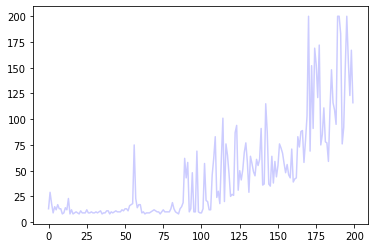